# PR9-1 Clusteringmodellen

## Opdracht

# Implementatie

## Library Imports

In [291]:
import pandas as pd
import random
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from sklearn import metrics
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import numpy as np
import sqlite3
import csv
import pyodbc

## Data inlezen en samenvoegen

In [292]:
sales_con = None
crm_con = None
staff_con = None
GO_SALES_PRODUCT_FORECASTData = None
GO_SALES_INVENTORY_LEVELSData = None



try : 
        sales_con = sqlite3.connect("../Assets/Week 2/go_sales.sqlite")
        print("Connected to go_sales sqlite.")


        crm_con = sqlite3.connect("../Assets/Week 2/go_crm.sqlite")
        print("Connected to go_crm sqlite.")


        staff_con = sqlite3.connect("../Assets/Week 2/go_staff.sqlite")
        print("Connected to go_staff sqlite.")

        GO_SALES_PRODUCT_FORECASTData = pd.read_csv("../Assets/Week 2/GO_SALES_PRODUCT_FORECASTData.csv")
        print("Connected to GO_SALES_PRODUCT_FORECASTData")

        GO_SALES_INVENTORY_LEVELSData = pd.read_csv("../Assets/Week 2/GO_SALES_INVENTORY_LEVELSData.csv", header=0, index_col=False)
        print("Connected to GO_SALES_INVENTORY_LEVELSData.csv")


except sqlite3.Error as error: 
        print("Failed to read data from sqlite table", error)

DataWarehouse_con = None

try : 
        pass
except : 
        pass




Connected to go_sales sqlite.
Connected to go_crm sqlite.
Connected to go_staff sqlite.
Connected to GO_SALES_PRODUCT_FORECASTData
Connected to GO_SALES_INVENTORY_LEVELSData.csv


In [293]:
global sales_branch
sales_branch = pd.read_sql_query("SELECT * FROM {}".format("sales_branch"),sales_con)
sales_branch = sales_branch[sales_branch.columns.drop(list(sales_branch.filter(regex="TRIAL")))]

global retailer_site
retailer_site = pd.read_sql_query("SELECT * FROM {}".format("retailer_site"),sales_con)
retailer_site = retailer_site[retailer_site.columns.drop(list(retailer_site.filter(regex="TRIAL")))]

global country
country = pd.read_sql_query("SELECT * FROM {}".format("country"),sales_con)
country = country[country.columns.drop(list(country.filter(regex="TRIAL")))]

global product
product = pd.read_sql_query("SELECT * FROM {}".format("product"),sales_con)
product = product[product.columns.drop(list(product.filter(regex="TRIAL")))]

global product_type
product_type = pd.read_sql_query("SELECT * FROM {}".format("product_type"),sales_con)
product_type = product_type[product_type.columns.drop(list(product_type.filter(regex="TRIAL")))]

global product_line
product_line = pd.read_sql_query("SELECT * FROM {}".format("product_line"),sales_con)
product_line = product_line[product_line.columns.drop(list(product_line.filter(regex="TRIAL")))]

global order_header
order_header = pd.read_sql_query("SELECT * FROM {}".format("order_header"),sales_con)
order_header = order_header[order_header.columns.drop(list(order_header.filter(regex="TRIAL")))]

global order_details
order_details = pd.read_sql_query("SELECT * FROM {}".format("order_details"),sales_con)
order_details = order_details[order_details.columns.drop(list(order_details.filter(regex="TRIAL")))]


In [294]:
dataset = pd.merge(sales_branch, country, left_on="COUNTRY_CODE", how="inner", right_on="COUNTRY_CODE")
orders = pd.merge(order_header, order_details, left_on="ORDER_NUMBER", how="inner", right_on="ORDER_NUMBER")
dataset = pd.merge(orders, dataset, left_on="SALES_BRANCH_CODE", how="inner", right_on="SALES_BRANCH_CODE")
dataset = pd.merge(dataset, product, left_on="PRODUCT_NUMBER", how="inner", right_on="PRODUCT_NUMBER")
dataset = pd.merge(dataset, product_type, left_on="PRODUCT_TYPE_CODE", how="inner", right_on="PRODUCT_TYPE_CODE")
dataset = pd.merge(dataset, product_line, left_on="PRODUCT_LINE_CODE", how="inner", right_on="PRODUCT_LINE_CODE")


dataset = dataset.loc[:,
                      [
                          "SALES_BRANCH_CODE", 
                          "COUNTRY_CODE",
                        #   "PRODUCT_TYPE_CODE",
                          "PRODUCT_LINE_CODE",
                          "UNIT_COST", 
                          "UNIT_PRICE",
                          "UNIT_SALE_PRICE",
                          "PRODUCTION_COST"
                      ]
                     ]

#aantal gekozen rijen verminderen voor minder drukte in visuals
# dataset = dataset.iloc[:3063]

print(dataset.columns)
display(dataset)

Index(['SALES_BRANCH_CODE', 'COUNTRY_CODE', 'PRODUCT_LINE_CODE', 'UNIT_COST',
       'UNIT_PRICE', 'UNIT_SALE_PRICE', 'PRODUCTION_COST'],
      dtype='object')


,SALES_BRANCH_CODE,COUNTRY_CODE,PRODUCT_LINE_CODE,UNIT_COST,UNIT_PRICE,UNIT_SALE_PRICE,PRODUCTION_COST
0,18,4,1,9.64,12.53,11.81,9.22
1,18,4,1,18.25,27.37,25.1,16.67
2,18,4,1,19.67,26.54,24.82,17.78
3,18,4,1,21.03,34.9,31.44,18.05
4,18,4,1,42.33,67.73,61.38,40.63
...,...,...,...,...,...,...,...
43058,15,10,2,19,38,33.25,19
43059,15,10,2,9,18,15.75,9
43060,15,10,2,40,80,70,40
43061,15,10,3,79.19,99,94.05,79.19


## One-hot encoding

In [295]:
# dummies_dataframe = pd.get_dummies(dataset.loc[:,
#                                                [
#                                                    "COUNTRY_CODE",
#                                                 #    "PRODUCT_TYPE_CODE",
#                                                    "PRODUCT_LINE_CODE"
#                                                    ]
#                                                    ])



# dummies_dataframe.columns


# dataset = pd.concat([dataset, dummies_dataframe], axis=1)

# dataset = dataset.drop([
#     "COUNTRY_CODE",
#     # "PRODUCT_TYPE_CODE",
#     "PRODUCT_LINE_CODE"], axis=1)

# dataset.columns

Index(['SALES_BRANCH_CODE', 'UNIT_COST', 'UNIT_PRICE', 'UNIT_SALE_PRICE',
       'PRODUCTION_COST', 'COUNTRY_CODE_1', 'COUNTRY_CODE_10',
       'COUNTRY_CODE_11', 'COUNTRY_CODE_12', 'COUNTRY_CODE_13',
       'COUNTRY_CODE_14', 'COUNTRY_CODE_16', 'COUNTRY_CODE_17',
       'COUNTRY_CODE_19', 'COUNTRY_CODE_2', 'COUNTRY_CODE_20',
       'COUNTRY_CODE_21', 'COUNTRY_CODE_22', 'COUNTRY_CODE_3',
       'COUNTRY_CODE_4', 'COUNTRY_CODE_5', 'COUNTRY_CODE_6', 'COUNTRY_CODE_7',
       'COUNTRY_CODE_8', 'COUNTRY_CODE_9', 'PRODUCT_LINE_CODE_1',
       'PRODUCT_LINE_CODE_2', 'PRODUCT_LINE_CODE_3', 'PRODUCT_LINE_CODE_4',
       'PRODUCT_LINE_CODE_5'],
      dtype='object')

## Cluster model bouwen

In [296]:
cluster_amount = 6

kmeans = KMeans(n_clusters=cluster_amount, random_state=42) 
prediction_results = kmeans.fit_predict(dataset)

prediction_results



array([2, 2, 2, ..., 0, 0, 2])

In [297]:
kmeans_centra = pd.DataFrame(kmeans.cluster_centers_)

# kmeans_centra = kmeans_centra.rename(columns = {
#                     0 : "SALES_BRANCH_CODE",
#                     1 : "COUNTRY_CODE",
#                     2 : "PRODUCT_TYPE_CODE",
#                     3 : "PRODUCT_LINE_CODE",
#                     4 : "UNIT_COST",
#                     5 : "UNIT_PRICE",
#                     6 : "UNIT_SALE_PRICE",
#                     7 : "PRODUCTION_COST"
#  }
# )

kmeans_centra

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,22.687921,69.161079,112.530172,108.937330,67.790701,0.054835,0.089960,0.040852,0.017520,0.020047,...,0.047928,0.055172,0.070923,0.037315,0.088359,2.920317e-01,1.823619e-01,4.262129e-01,3.802514e-15,9.939353e-02
1,22.491604,462.109081,726.776688,678.103647,447.748442,0.052705,0.072761,0.035448,0.016791,0.018657,...,0.038713,0.050840,0.060634,0.037780,0.072761,5.904851e-01,2.775558e-16,2.470246e-15,1.720846e-15,4.095149e-01
2,22.701206,15.823333,24.871335,24.031048,15.596427,0.053999,0.092774,0.039209,0.014356,0.012491,...,0.047536,0.051266,0.065276,0.032226,0.084577,4.008501e-01,1.737509e-01,1.336312e-01,2.418459e-01,4.992193e-02
3,22.854618,552.489221,1123.986683,1052.931478,517.692048,0.073896,0.063454,0.079518,0.043373,0.039357,...,0.027309,0.044177,0.061847,0.024900,0.054618,-1.720846e-15,2.775558e-16,-1.720846e-15,-8.326673e-17,1.000000e+00
4,22.426168,334.857277,541.756168,515.551508,327.809209,0.054829,0.085981,0.035514,0.016199,0.014953,...,0.045483,0.064174,0.062305,0.037383,0.080997,3.676012e-01,1.520249e-01,3.608225e-16,8.881784e-16,4.803738e-01
5,22.498886,194.655648,313.157090,295.452467,188.838357,0.052213,0.091372,0.027698,0.002229,0.010188,...,0.047437,0.057307,0.059535,0.035021,0.093601,5.870742e-01,1.209806e-01,2.919452e-01,2.525757e-15,-2.178813e-15


In [298]:
dataset["Centrum"] = prediction_results

display(dataset)

,SALES_BRANCH_CODE,UNIT_COST,UNIT_PRICE,UNIT_SALE_PRICE,PRODUCTION_COST,COUNTRY_CODE_1,COUNTRY_CODE_10,COUNTRY_CODE_11,COUNTRY_CODE_12,COUNTRY_CODE_13,...,COUNTRY_CODE_6,COUNTRY_CODE_7,COUNTRY_CODE_8,COUNTRY_CODE_9,PRODUCT_LINE_CODE_1,PRODUCT_LINE_CODE_2,PRODUCT_LINE_CODE_3,PRODUCT_LINE_CODE_4,PRODUCT_LINE_CODE_5,Centrum
0,18,9.64,12.53,11.81,9.22,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,2
1,18,18.25,27.37,25.1,16.67,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,2
2,18,19.67,26.54,24.82,17.78,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,2
3,18,21.03,34.9,31.44,18.05,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,2
4,18,42.33,67.73,61.38,40.63,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43058,15,19,38,33.25,19,False,True,False,False,False,...,False,False,False,False,False,True,False,False,False,2
43059,15,9,18,15.75,9,False,True,False,False,False,...,False,False,False,False,False,True,False,False,False,2
43060,15,40,80,70,40,False,True,False,False,False,...,False,False,False,False,False,True,False,False,False,0
43061,15,79.19,99,94.05,79.19,False,True,False,False,False,...,False,False,False,False,False,False,True,False,False,0


In [299]:
dataset.groupby('Centrum', as_index = False)['Centrum'].count()

,Centrum
0,11872
1,2144
2,23056
3,1245
4,1605
5,3141


## Visuals

In [300]:
# plt.scatter(dataset['UNIT_SALE_PRICE'], dataset['Centrum'], color = 'k')
# plt.show()

In [301]:
pca = PCA(2)
pca_res = pca.fit_transform(dataset)
dataset["Cluster"] = kmeans.labels_
dataset["X"] = pca_res[:,0]
dataset["Y"] = pca_res[:,1]


display(dataset)

,SALES_BRANCH_CODE,UNIT_COST,UNIT_PRICE,UNIT_SALE_PRICE,PRODUCTION_COST,COUNTRY_CODE_1,COUNTRY_CODE_10,COUNTRY_CODE_11,COUNTRY_CODE_12,COUNTRY_CODE_13,...,COUNTRY_CODE_9,PRODUCT_LINE_CODE_1,PRODUCT_LINE_CODE_2,PRODUCT_LINE_CODE_3,PRODUCT_LINE_CODE_4,PRODUCT_LINE_CODE_5,Centrum,Cluster,X,Y
0,18,9.64,12.53,11.81,9.22,False,False,False,False,False,...,False,True,False,False,False,False,2,2,-229.435437,4.511392
1,18,18.25,27.37,25.1,16.67,False,False,False,False,False,...,False,True,False,False,False,False,2,2,-206.501821,4.338011
2,18,19.67,26.54,24.82,17.78,False,False,False,False,False,...,False,True,False,False,False,False,2,2,-206.318019,2.446070
3,18,21.03,34.9,31.44,18.05,False,False,False,False,False,...,False,True,False,False,False,False,2,2,-196.480193,6.551421
4,18,42.33,67.73,61.38,40.63,False,False,False,False,False,...,False,True,False,False,False,False,2,2,-142.563743,1.167723
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43058,15,19,38,33.25,19,False,True,False,False,False,...,False,False,True,False,False,False,2,2,-193.827773,8.740674
43059,15,9,18,15.75,9,False,True,False,False,False,...,False,False,True,False,False,False,2,2,-223.908196,8.176361
43060,15,40,80,70,40,False,True,False,False,False,...,False,False,True,False,False,False,0,0,-130.660657,9.926067
43061,15,79.19,99,94.05,79.19,False,True,False,False,False,...,False,False,False,True,False,False,0,0,-77.095190,-22.893535


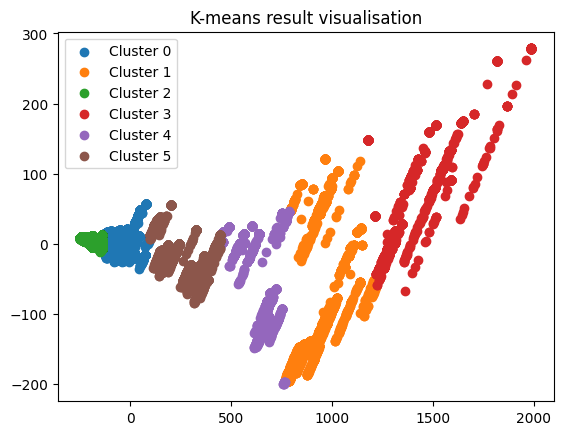

In [302]:

for i in range(cluster_amount) : 
    cluster = dataset[dataset["Cluster"] == i]
    plt.scatter(cluster["X"], cluster["Y"], label=f"Cluster {i}" )

plt.legend()
plt.title("K-means result visualisation")
plt.xlabel="X"
plt.ylabel="Y"

plt.show()
